In [6]:
import pandas as pd

df = pd.read_csv("../data/clean_access.csv")

Domain-Level Analysis

1. Which domains (health, education, government, e-commerce, etc.) have the most violations?

In [7]:
violations_per_domain = df.groupby('domain_category')['violation_count'].sum().sort_values(ascending=False)
print(violations_per_domain)

domain_category
News and Media                     8568
Technology Science and Research    4211
Educational Platforms              3985
Streaming Platforms                3161
E-commerce                         2640
Government and Public Services     2310
Health and Wellness                1123
Technology / Science / Research      23
Ecommerce                             8
Name: violation_count, dtype: int64


2. Which domains have the most severe violations?

In [8]:
avg_violations_per_page = df.groupby('domain_category')['violation_count'].mean().sort_values(ascending=False)
print(avg_violations_per_page)

domain_category
News and Media                     9.114894
Ecommerce                          8.000000
E-commerce                         7.674419
Educational Platforms              6.930435
Streaming Platforms                6.827214
Health and Wellness                6.806061
Technology Science and Research    6.652449
Government and Public Services     6.078947
Technology / Science / Research    1.000000
Name: violation_count, dtype: float64


3. How do violations spread across categories (syntactic, semantic, layout)?


In [9]:
severity_per_domain = df.groupby('domain_category')['high_severity'].sum().sort_values(ascending=False)
print(severity_per_domain)

domain_category
News and Media                     466
Technology Science and Research    363
Educational Platforms              333
Streaming Platforms                236
E-commerce                         189
Government and Public Services     161
Health and Wellness                 84
Technology / Science / Research     18
Ecommerce                            1
Name: high_severity, dtype: int64


Visualization

/var/folders/l2/4k7ng21922d2d31w2l8bd03w0000gn/T/ipykernel_40072/4092448064.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=violations_per_domain.index, y=violations_per_domain.values, palette='viridis')


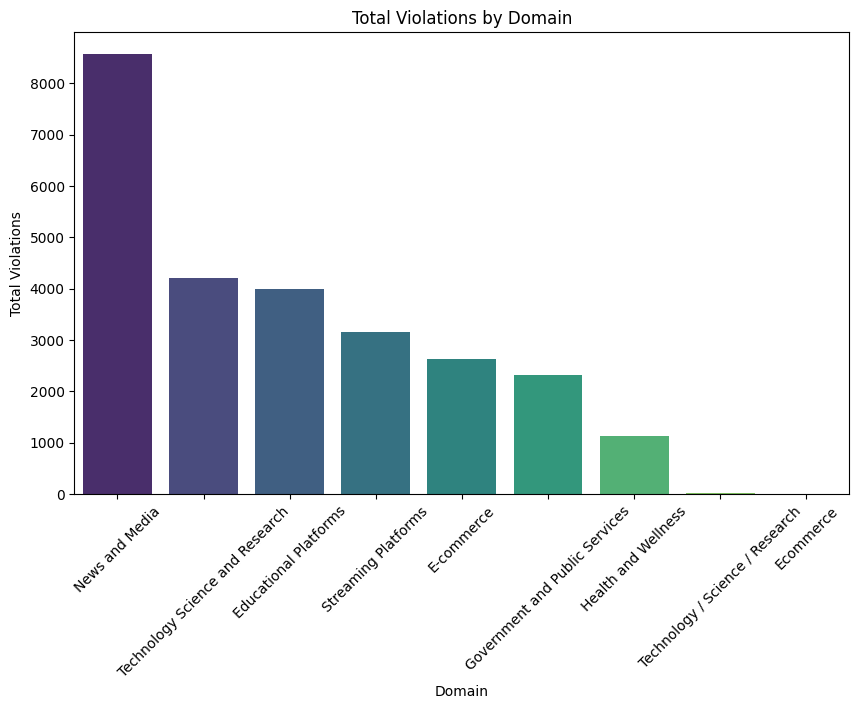

/var/folders/l2/4k7ng21922d2d31w2l8bd03w0000gn/T/ipykernel_40072/4092448064.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_per_domain.index, y=severity_per_domain.values, palette='magma')


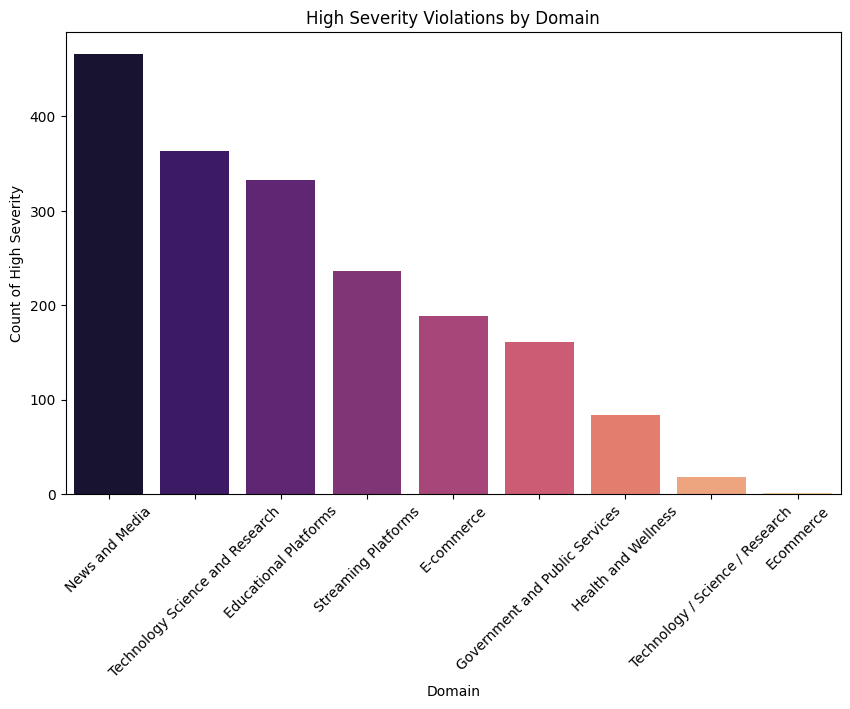

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart: total violations
plt.figure(figsize=(10,6))
sns.barplot(x=violations_per_domain.index, y=violations_per_domain.values, palette='viridis')
plt.title("Total Violations by Domain")
plt.ylabel("Total Violations")
plt.xlabel("Domain")
plt.xticks(rotation=45)
plt.savefig(
    "../figures/total_violations_by_domain.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

# Bar chart: high severity
plt.figure(figsize=(10,6))
sns.barplot(x=severity_per_domain.index, y=severity_per_domain.values, palette='magma')
plt.title("High Severity Violations by Domain")
plt.ylabel("Count of High Severity")
plt.xlabel("Domain")
plt.xticks(rotation=45)
plt.savefig(
    "../figures/high_severity_per_domain.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


Domain & Severity Inequality Analysis

In [14]:
impact_weights = {
    "minor": 1,
    "moderate": 2,
    "serious": 3
}

df['impact_weight'] = df['violation_impact'].map(impact_weights)


/var/folders/l2/4k7ng21922d2d31w2l8bd03w0000gn/T/ipykernel_40072/348517811.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=domain_summary.sort_values('total_harm', ascending=False),


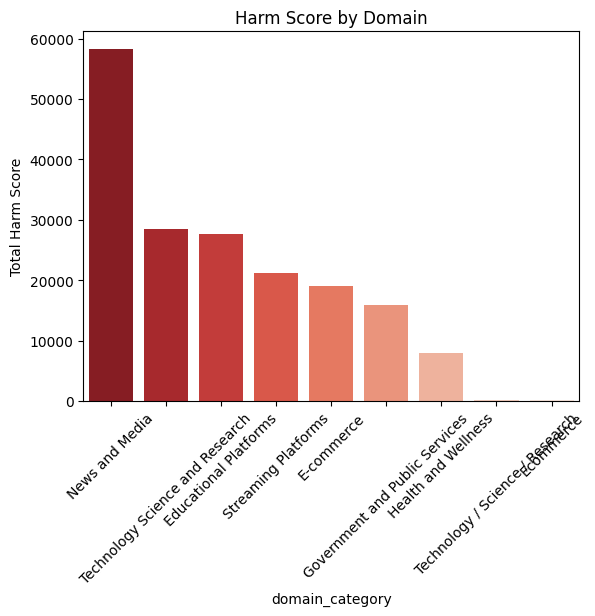

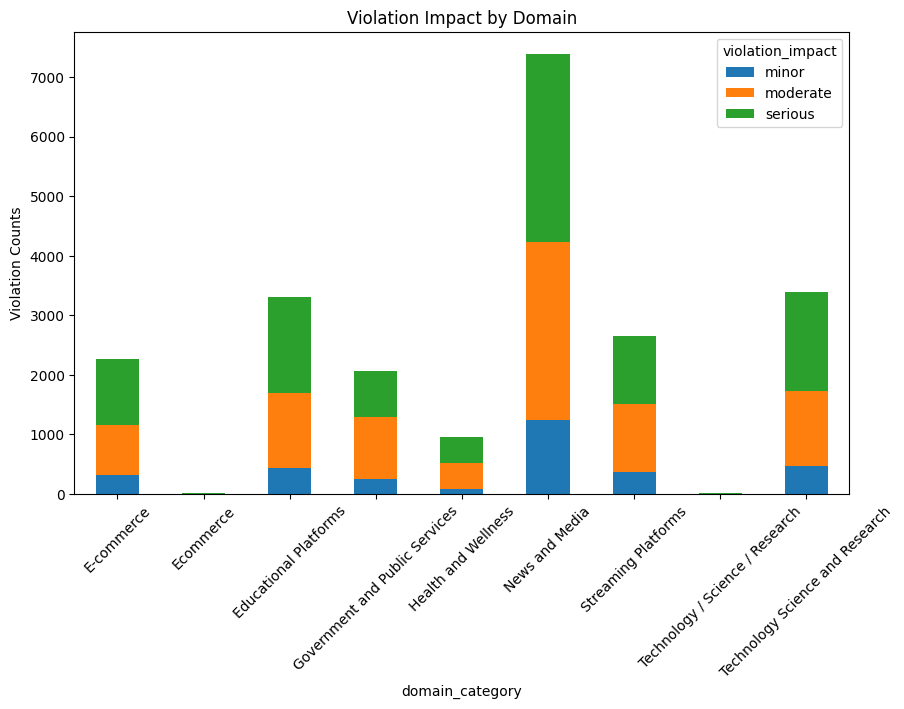

In [16]:
df['harm_score'] = df['violation_count'] * df['violation_score'] * df['impact_weight']
domain_summary = df.groupby('domain_category').agg(
    total_violations = ('violation_count', 'sum'),
    avg_violation_score = ('violation_score', 'mean'),
    total_harm = ('harm_score', 'sum')
).reset_index()

impact_summary = df.groupby(['domain_category', 'violation_impact']).agg(
    count=('violation_count', 'sum')
).reset_index()

impact_pivot = impact_summary.pivot(index='domain_category', columns='violation_impact', values='count').fillna(0)

impact_pivot['total'] = impact_pivot.sum(axis=1)
impact_pivot['%serious'] = (impact_pivot['serious'] / impact_pivot['total']) * 100
impact_pivot['%minor'] = (impact_pivot['minor'] / impact_pivot['total']) * 100


top_violations = df.groupby(['domain_category','violation_category']).agg(
    total_count=('violation_count','sum')
).reset_index()

top_violations = top_violations.sort_values(['domain_category','total_count'], ascending=[True,False])
top_violations_top10 = top_violations.groupby('domain_category').head(10)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=domain_summary.sort_values('total_harm', ascending=False),
            x='domain_category', y='total_harm', palette='Reds_r')
plt.xticks(rotation=45)
plt.ylabel("Total Harm Score")
plt.title("Harm Score by Domain")
plt.savefig(
    "../figures/harm_score_by_domain.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()



impact_pivot[['minor','moderate','serious']].plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel("Violation Counts")
plt.title("Violation Impact by Domain")
plt.xticks(rotation=45)
plt.savefig(
    "../figures/violation_impact_by_domain.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()




---------------------------------------------------------------------

In [17]:
# 1.2
violation_counts = df['violation_name'].value_counts()
top_20 = violation_counts.head(20)
total_violations = violation_counts.sum()

top_violations_df = top_20.reset_index()
top_violations_df.columns = ['violation_name', 'count']

top_violations_df['percentage'] = (
    top_violations_df['count'] / total_violations * 100
).round(2)
top_violations_df.to_csv("../data/q1_top_violations.csv", index=False)


In [18]:
# 1.3
top_15_violations = df['violation_name'].value_counts().head(15).index
df_top15 = df[df['violation_name'].isin(top_15_violations)]
violations_by_domain = pd.crosstab(
    df_top15['domain_category'],
    df_top15['violation_name']
)
violations_by_domain.to_csv("../data/q1_violations_by_domain.csv")


In [19]:
# 1.4
category_counts = df['violation_category'].value_counts()
category_df = category_counts.reset_index()
category_df.columns = ['violation_category', 'count']

category_df['percentage'] = (
    category_df['count'] / category_df['count'].sum() * 100
).round(2)
category_df.to_csv("../data/q1_category_breakdown.csv", index=False)


In [20]:
# 1.5
impact_counts = df['violation_impact'].value_counts()
impact_df = impact_counts.reset_index()
impact_df.columns = ['violation_impact', 'count']

impact_df['percentage'] = (
    impact_df['count'] / impact_df['count'].sum() * 100
).round(2)
critical_by_domain = (
    df[df['violation_impact'] == 'critical']
    .groupby('domain_category')
    .size()
    .reset_index(name='critical_count')
    .sort_values(by='critical_count', ascending=False)
)
impact_df.to_csv("../data/q1_impact_breakdown.csv", index=False)
